# 4주차
- ChatGPT Tweets sentiment analysis
- 감성분석 모델링

## 데이터 이해
- Text: chatgpt 생성 트윗 내용
- negative: 트윗이 부정적 내용일 확률
- neutral: 트윗이 중립적 내용일 확률
- positive: 트윗이 긍정적 내용일 확률
- predicted_label: 예측된 트윗 라벨
- date: 트윗 수집 날짜
- likes: 트윗이 받은 좋아요 개수
- location: 트윗이 작성된 위치
- followers: 트윗 작성자의 팔로워 수 
- following: 트윗 작성자의 팔로잉 수
- retweets: 해당 트윗이 리트윗된 수
- replies: 해당 트윗에 달린 답글 수 

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

# preprocessing
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# visulization
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.pipeline import Pipeline # 전처리-모델링 과정을 연결해주는 시스템
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# valuation
from sklearn.metrics import classification_report

# validation
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

In [2]:
# 데이터 불러오기
df = pd.read_csv("C:/Users/sssum/Downloads/chatgpt_sentiment.csv")
df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies
0,If I were a journalist or reporter writing cli...,0.947877,0.040978,0.011144,negative,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0
1,Imagine if the mid season twist was that theyr...,0.031874,0.156266,0.811859,positive,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2
2,I see the difference between leader and employ...,0.158342,0.312784,0.528873,positive,2023-02-10 23:59:18+00:00,4,NaN,23,577,0,1
3,Which means your job is at risk Bill Gates say...,0.023860,0.931395,0.044745,neutral,2023-02-10 23:59:16+00:00,0,NaN,108,224,0,0
4,What have you been using Chatgpt for?,0.005627,0.968457,0.025916,neutral,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1


In [3]:
# 데이터 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975450 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             975027 non-null  object 
 1   negative         975450 non-null  float64
 2   neutral          975450 non-null  float64
 3   positive         975450 non-null  float64
 4   predicted_label  975450 non-null  object 
 5   date             975450 non-null  object 
 6   likes            975450 non-null  int64  
 7   location         705265 non-null  object 
 8   followers        975450 non-null  int64  
 9   following        975450 non-null  int64  
 10  retweets         975450 non-null  int64  
 11  replies          975450 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 89.3+ MB


Text, location 컬럼에 결측치 있음

In [4]:
# 데이터 통계 정보 확인
df.describe()

,negative,neutral,positive,likes,followers,following,retweets,replies
count,975450.000000,975450.000000,975450.000000,975450.000000,9.754500e+05,9.754500e+05,975450.000000,975450.000000
mean,0.224028,0.437321,0.338650,11.961189,3.231735e+04,1.573738e+03,1.765541,1.114315
std,0.349075,0.374737,0.377395,355.771275,7.281230e+05,9.618419e+03,57.776420,36.731214
min,0.001543,0.005018,0.003674,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.006844,0.052123,0.018617,0.000000,8.600000e+01,1.480000e+02,0.000000,0.000000
50%,0.024687,0.355728,0.116684,1.000000,4.390000e+02,4.600000e+02,0.000000,0.000000
75%,0.254022,0.846569,0.746904,2.000000,2.041000e+03,1.214000e+03,0.000000,1.000000
max,0.986359,0.993227,0.990427,111653.000000,1.287402e+08,1.526451e+06,13072.000000,19942.000000


In [5]:
# 범주형 컬럼 분포 확인
df.describe(include='object')

,Text,predicted_label,date,location
count,975027,975450,975450,705265
unique,850122,3,870539,93684
top,ChatGPT,neutral,2023-01-12 10:30:34+00:00,United States
freq,16386,442168,36,11209


- negative, neutral, positive 라벨링을 진행하고, 각 감성마다 분포 파악
- 데이터 개수가 약 97만개로 모델링시 시간이 매우 오래 걸리는 점을 감안하여 샘플링을 진행했으나 과적합이 발생하여 샘플링은 진행하지 않기로 결정
- text와 라벨 변수(감성) 외에 likes, follwers 등 변수들은 EDA 과정에서 활용하고 모델링에서는 활용하지 않음

In [6]:
# 리뷰 텍스트 형태 확인
df['Text'][0]

"If I were a journalist or reporter writing click-bait for a living then I'd be worried: BuzzFeed Inc. said it would rely on ChatGPT creator OpenAI to enhance its quizzes and personalize some content for audiences via"

텍스트는 html 형식이 아니므로 소문자화, 구두점 제거, stopwords 제거로 1차 전처리 과정을 거침

## 데이터 전처리
이번 챕터는 텍스트 분석을 진행해야 하므로 먼저 데이터 전처리를 진행 후 EDA 진행

In [7]:
# 결측치 제거
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704971 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             704971 non-null  object 
 1   negative         704971 non-null  float64
 2   neutral          704971 non-null  float64
 3   positive         704971 non-null  float64
 4   predicted_label  704971 non-null  object 
 5   date             704971 non-null  object 
 6   likes            704971 non-null  int64  
 7   location         704971 non-null  object 
 8   followers        704971 non-null  int64  
 9   following        704971 non-null  int64  
 10  retweets         704971 non-null  int64  
 11  replies          704971 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 69.9+ MB


In [8]:
# 라벨링 0-negative, 1-positive, 2-neutral
label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
df['sentiment_label'] = df['predicted_label'].map(label_mapping)

df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies,sentiment_label
0,If I were a journalist or reporter writing cli...,0.947877,0.040978,0.011144,negative,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0,0
1,Imagine if the mid season twist was that theyr...,0.031874,0.156266,0.811859,positive,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2,1
4,What have you been using Chatgpt for?,0.005627,0.968457,0.025916,neutral,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1,2
5,ChatGPT is sick of me.,0.983498,0.008941,0.007562,negative,2023-02-10 23:59:06+00:00,1,"Dubai, United Arab Emirates",136,387,1,0,0
6,I should ask ChatGPT to expound upon each of m...,0.042379,0.900259,0.057361,neutral,2023-02-10 23:58:57+00:00,0,bk ny,967,2431,0,0,2


In [9]:
# negative와 같이 확률값 컬럼과 predicted_label 컬럼 제거
data = df.drop(columns=['date', 'location', 'negative', 'positive', 'neutral', 'predicted_label'], axis=1)
data.head()

,Text,likes,followers,following,retweets,replies,sentiment_label
0,If I were a journalist or reporter writing cli...,1,2012,388,0,0,0
1,Imagine if the mid season twist was that theyr...,8,19855,5722,1,2,1
4,What have you been using Chatgpt for?,1,11155,478,0,1,2
5,ChatGPT is sick of me.,1,136,387,1,0,0
6,I should ask ChatGPT to expound upon each of m...,0,967,2431,0,0,2


In [10]:
# 사용할 컬럼 할당
data = df[['Text', 'sentiment_label']]
data.head()

,Text,sentiment_label
0,If I were a journalist or reporter writing cli...,0
1,Imagine if the mid season twist was that theyr...,1
4,What have you been using Chatgpt for?,2
5,ChatGPT is sick of me.,0
6,I should ask ChatGPT to expound upon each of m...,2


In [12]:
# 텍스트 전처리 함수 생성
def clean_text(tweet):
    temp=tweet.lower()
    temp = re.sub("'", "", temp)
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("chatgpt","",temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    punc=string.punctuation
    temp=temp.translate(str.maketrans('','',punc))
    
    #removing stopwords
    new_list=[]
    words=word_tokenize(temp)
    sws=stopwords.words('english')
    for word in words:
        if word not in sws:
            new_list.append(word)
    
    temp=' '.join(new_list)
    return temp

In [13]:
# 텍스트 데이터에 함수 적용
data['Text'] = data['Text'].apply(clean_text)

C:\Users\sssum\AppData\Local\Temp\ipykernel_17684\1034059177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = data['Text'].apply(clean_text)


In [14]:
# 적용된 값 확인
data.head()

,Text,sentiment_label
0,journalist reporter writing clickbait living i...,0
1,imagine mid season twist theyre dating would i...,1
4,using,2
5,sick,0
6,ask expound upon note entries,2


In [15]:
# 표제어 추출 함수 작성
def lemmatize(text):
    new_list=[]
    lemma=WordNetLemmatizer()
    words=word_tokenize(text)
    for word in words:
        new_list.append(lemma.lemmatize(word))
        
    return ' '.join(new_list)

In [16]:
# 함수 적용
data['Text'] = data['Text'].apply(lemmatize)

C:\Users\sssum\AppData\Local\Temp\ipykernel_17684\269564076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = data['Text'].apply(lemmatize)


In [17]:
# 적용된 값 확인
data.head()

,Text,sentiment_label
0,journalist reporter writing clickbait living i...,0
1,imagine mid season twist theyre dating would i...,1
4,using,2
5,sick,0
6,ask expound upon note entry,2


## EDA

<Axes: xlabel='sentiment_label', ylabel='count'>

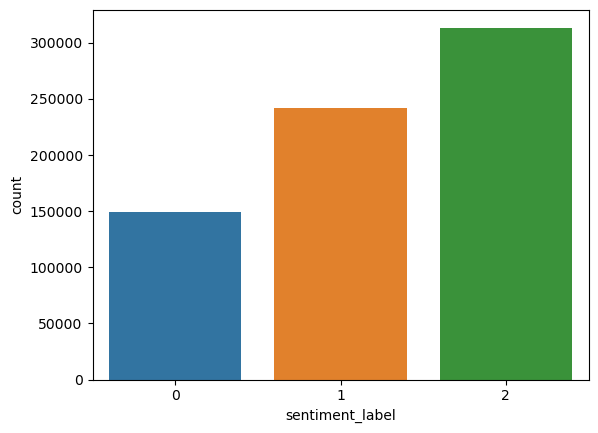

In [18]:
# 라벨 변수 분포 확인
sns.countplot(x='sentiment_label', data=df)

- 중립이 가장 많고, 긍정, 부정순
- 라벨 변수 분포를 동일하게 샘플링 진행

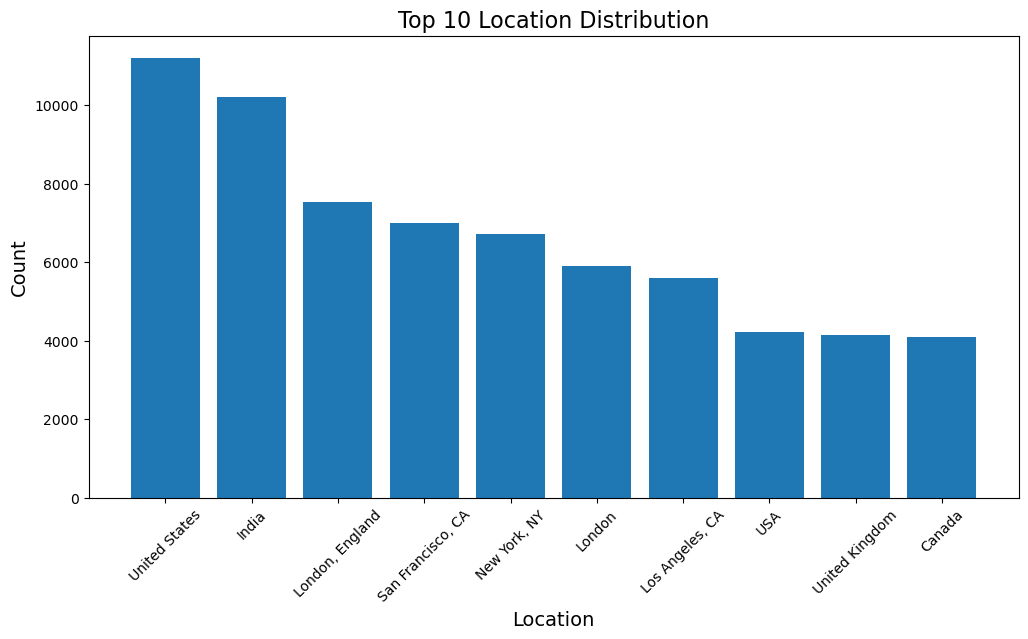

In [19]:
# location 컬럼 상위 10개 분포 확인
top_10_locations = df['location'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations.index, top_10_locations.values)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Top 10 Location Distribution', fontsize=16)
plt.xticks(rotation=45)
plt.show()

- 미국에서 작성된 트윗이 가장 많고, 그 다음으로 인도가 많음
- 동일한 나라여도 다르게 작성된 값이 많음
- 모델링에는 사용하지 않는 것으로 결정함

In [20]:
# 좋아요 개수 상위 10개 텍스트값 확인
pd.set_option('display.max_colwidth', None)
top_10_likes = df.nlargest(10, 'likes')[['Text', 'likes']]

top_10_likes

,Text,likes
170270,Time it took to get 100 million users: Netflix: 10 years Gmail: 5 years Twitter: 5 years Facebook: 4.5 years WhatsApp: 3.5 years Instagram: 2.5 years TikTok: 9 months ChatGPT: 2 months Pirate Bay: 1 day after Netflix cancelled shared passwords and Gen-Z discovered torrents.,111653
950217,"POV: You're a Senior Data Engineer at Twitter. Elon asks what you've done this week. You've done nothing. Frantically, you open ChatGPT.",62310
188438,ChatGPT is everywhere and everyone is using it. But most academics don't know how to use it *smartly.* Here's how to use ChatGPT intelligently (and ethically) for academic purposes:,60325
656600,ChatGPT is a FREE assistant. But most people dont know the best ways to use it. Here are 8 ways ChatGPT can save you thousands of hours in 2023:,60197
368458,ChatGPT passed a Wharton MBA exam. Time to overhaul education.,58667
925357,ChatGPT launched on wednesday. today it crossed 1 million users!,52707
647959,Everyones using ChatGPT. But almost everyone's STUCK in beginner mode. 10 techniques to get massively ahead with AI: (cut-and-paste these prompts),47592
456058,imagine a ChatGPT browser extension that reads the Terms and Conditions agreement and flags anything that is non-standard,42849
349058,chatgpt will never replicate the charm and syntax of an undergraduate paper where the student has neither been to class nor read more than the abstract of a paper there's a magic nothingness that they're able to conjure with sheer grit and desperation that a.i. could never,42441
106346,Looks like ChatGPT is gonna need to go in the shop for repairs because it's been BUCK BROKEN,41801


- 111,653개의 좋아요를 받은 트윗 내용은 1억명의 고객을 모으는데 걸린 시간을 각 플랫폼별로 비교한 내용, ChatGPT가 그만큼 고객을 빨리 모았다는 것을 말함
- 62,310개의 좋아요를 받은 트윗 내용은 ChatGPT를 홍보하기 위한 내용

In [21]:
# 리트윗 개수 상위 10개 텍스트값 확인
top_10_retweets = df.nlargest(10, 'retweets')[['Text', 'retweets']]

top_10_retweets

,Text,retweets
656600,ChatGPT is a FREE assistant. But most people dont know the best ways to use it. Here are 8 ways ChatGPT can save you thousands of hours in 2023:,13072
188438,ChatGPT is everywhere and everyone is using it. But most academics don't know how to use it *smartly.* Here's how to use ChatGPT intelligently (and ethically) for academic purposes:,12506
936279,We asked Open AI's ChatGPT what it thought of the unique architecture that Quai has implemented to solve the blockchain trilemma... What do you think of its response?,10526
170270,Time it took to get 100 million users: Netflix: 10 years Gmail: 5 years Twitter: 5 years Facebook: 4.5 years WhatsApp: 3.5 years Instagram: 2.5 years TikTok: 9 months ChatGPT: 2 months Pirate Bay: 1 day after Netflix cancelled shared passwords and Gen-Z discovered torrents.,10242
502485,Best AI Tools You Need To Know,9891
427949,"Exclusive: OpenAI used outsourced Kenyan workers earning less than per hour to make ChatGPT less toxic, my investigation found (Thread)",9545
106346,Looks like ChatGPT is gonna need to go in the shop for repairs because it's been BUCK BROKEN,9517
600060,ultra-modern generative ai: AI2 AI21 mdm gpt-J gpt-3 x-clip bloom cohere gopher dalle 2 craiyon tabnine jukebox chatGPT *** anthropic codegeex nvidia get3d dreamfusion stable diffusion meta make-a-video,9501
667945,AI tools that didn't exist one year ago: ChatGPT Whisper GPT-3 Codex GitHub Copilot InstructGPT Text-to-product AI slides DALLE + API Midjourney Stable Diffusion Runway videos Email AI AI chrome extensions Replit Ghostwriter No-code AI app builders Ben's bites what else?,8989
647959,Everyones using ChatGPT. But almost everyone's STUCK in beginner mode. 10 techniques to get massively ahead with AI: (cut-and-paste these prompts),8796


- 13,072개의 리트윗을 받은 트윗의 내용은 ChatGPT를 사용하는 8가지 방법에 대한 내용
- 12,506개의 리트윗을 받은 트윗의 내용은 ChatGPT를 사용해서 공부하는 방법에 대한 내용

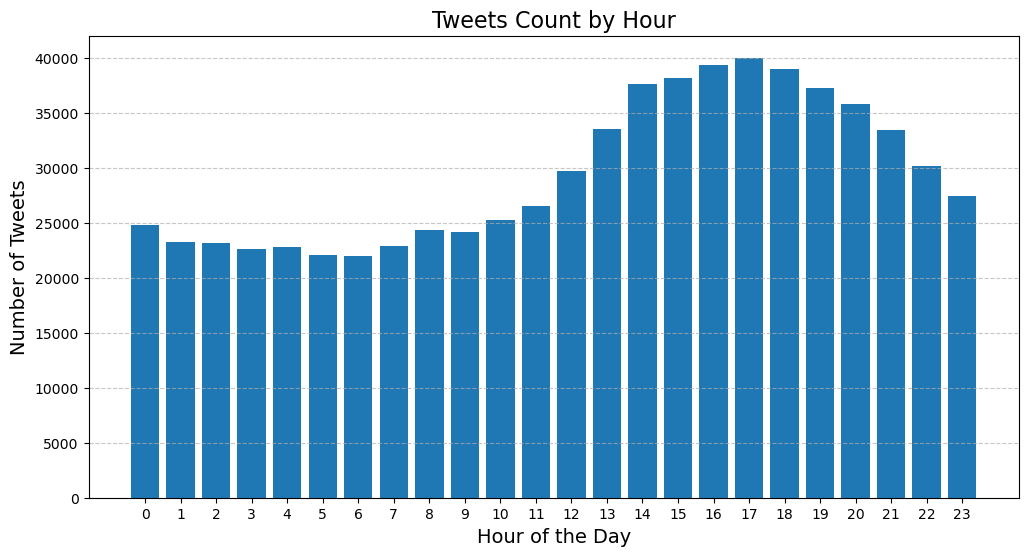

In [22]:
# 트윗이 작성된 시간대 시각화
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour # 시간대 추출출

hourly_counts = df['hour'].value_counts().sort_index() # 시간대별 트윗개수 집계계

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.title('Tweets Count by Hour', fontsize=16)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

오후 6시에 가장 많은 트윗이 작성되었고, 오전 5, 6시에 비교적 가장 적은 트윗이 작성됨 

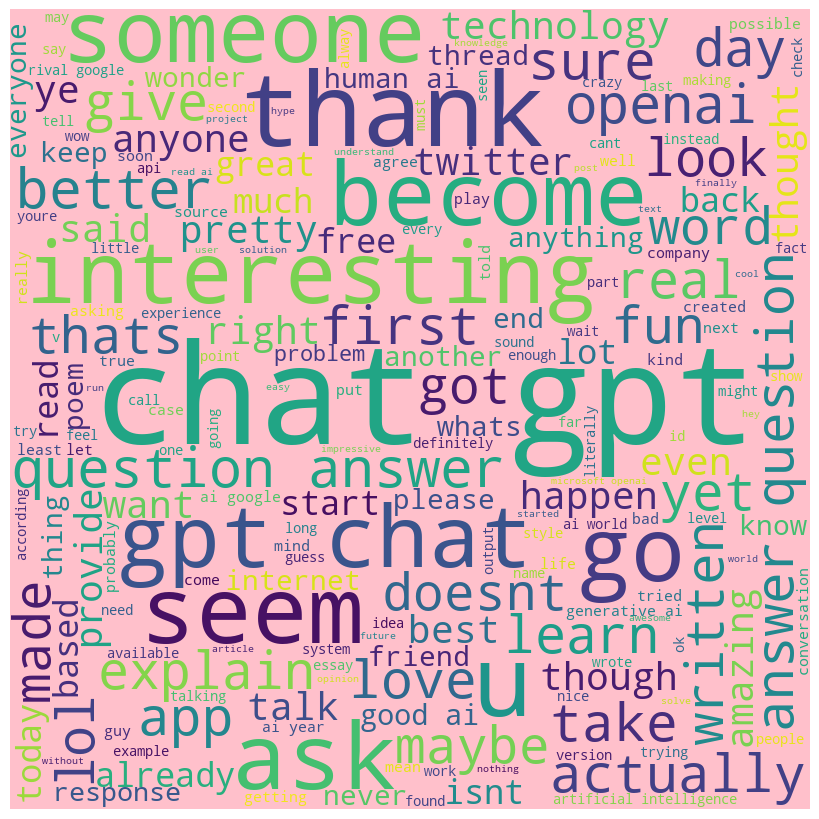

In [23]:
# 트윗 워드클라우드
comment_words = ''
stopwords = set(STOPWORDS)

for val in data.Text:
    val = str(val)
    tokens = val.split()
    
    tokens = list(set([word.lower() for word in tokens]))
    
    comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width=800, height=800,
                      background_color='pink',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

'chat gpt', 'interesting', 'thank' 단어의 비율이 높았음.

## 모델링 (텍스트만 활용)

In [24]:
# 샘플링 데이터 값 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704971 entries, 0 to 975449
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Text             704971 non-null  object
 1   sentiment_label  704971 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 16.1+ MB


In [25]:
# 데이터 분할
X = data['Text'].values.astype('str')
y = data['sentiment_label']

In [26]:
# countvectorizer 함수에 학습
cv = CountVectorizer(lowercase=True, stop_words='english')
X = cv.fit_transform(X)

In [27]:
# train, test 데이터 분할
train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

### 나이브베이즈

In [28]:
# NaiveBayes 모델링
nb = MultinomialNB()
nb.fit(train_input, train_target)
pred = nb.predict(test_input)

In [29]:
# train 성능 확인
print(nb.score(train_input, train_target))

0.7353309360682014


In [30]:
# test 성능 확인
print(classification_report(test_target, pred))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62     29898
           1       0.69      0.72      0.70     48339
           2       0.72      0.72      0.72     62758

    accuracy                           0.69    140995
   macro avg       0.68      0.68      0.68    140995
weighted avg       0.69      0.69      0.69    140995



성능 평가 결과, 약간의 과적합 발생

In [31]:
# 파이프라인 생성
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(lowercase=True, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [32]:
# 데이터 분할
X = data['Text']
y = data['sentiment_label']

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# 파이프라인 학습
nb_pipeline.fit(train_input, train_target)

Pipeline(steps=[('bow', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [34]:
# 예측값 생성
pred_target = nb_pipeline.predict(test_input)

In [35]:
# train 성능 평가
print(nb_pipeline.score(train_input, train_target))

0.718028781366583


In [36]:
# test 성능 평가
print(classification_report(test_target, pred_target))

              precision    recall  f1-score   support

           0       0.80      0.34      0.48     29898
           1       0.71      0.67      0.69     48339
           2       0.64      0.84      0.73     62758

    accuracy                           0.68    140995
   macro avg       0.72      0.62      0.63    140995
weighted avg       0.70      0.68      0.66    140995



샘플링 O
- train accuracy: 0.8659
- test accuracy: 0.61

샘플링 X
- train accuracy: 0.7180
- test accuracy: 0.68

샘플링을 하지 않았을 때, 확실히 과적합이 줄어들었음.

### 로지스틱 회귀

In [37]:
# 파이프라인 생성
lr_pipeline = Pipeline([
    ('bow', CountVectorizer(lowercase=True, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

In [38]:
# 파이프라인 학습
lr_pipeline.fit(train_input, train_target)

C:\Users\sssum\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('bow', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [39]:
# 예측값 생성
pred_target = lr_pipeline.predict(test_input)

In [40]:
# train 성능 평가
print(nb_pipeline.score(train_input, train_target))

0.718028781366583


In [41]:
# test 성능 평가
print(classification_report(test_target, pred_target))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64     29898
           1       0.75      0.73      0.74     48339
           2       0.72      0.81      0.76     62758

    accuracy                           0.73    140995
   macro avg       0.73      0.70      0.71    140995
weighted avg       0.73      0.73      0.73    140995



샘플링 O
- train accuracy: 0.8659
- test accuracy: 0.62

샘플링 X
- train accuracy: 0.7180
- test accuracy: 0.73

- 나이브 베이즈, 로지스틱 회귀의 train 정확도는 똑같지만, test 정확도가 로지스틱이 조금 더 높음.
- 로지스틱 회귀는 과소적합이 발생했음을 알 수 있음음

## 하이퍼 파라미터 튜닝

In [42]:
# 나이브베이즈 규제값 튜닝
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(lowercase=True, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()) 
])

param_grid = {"classifier__alpha": [0.1, 0.5, 1.0, 10, 100]}

grid_search = GridSearchCV(nb_pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(train_input, train_target)

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 정확도:", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
최적의 파라미터: {'classifier__alpha': 0.5}
최적의 정확도: 0.6808091121701069


In [43]:
# train 데이터 정확도
train_accuracy = grid_search.best_estimator_.score(train_input, train_target)

# test 데이터 정확도
test_accuracy = grid_search.best_estimator_.score(test_input, test_target)

print(train_accuracy, test_accuracy)

0.7367175198944635 0.6821731267066208


나이브 베이즈 모델의 규제값 튜닝 후, 과적합이 조금 더 심해짐

In [44]:
# 로지스틱 회귀 규제값 튜닝
lr_pipeline = Pipeline([
    ('bow', CountVectorizer(lowercase=True, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression()) 
])

# 파이프라인 제작하고 나서는 파리미터 이름을 classifier__를 앞에 붙어주어야 함
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__max_iter': [100, 300, 500]
}

grid_search = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(train_input, train_target)

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 정확도:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
최적의 파라미터: {'classifier__C': 1, 'classifier__max_iter': 500}
최적의 정확도: 0.7326233728965231


C:\Users\sssum\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
# train 데이터 정확도
train_accuracy = grid_search.best_estimator_.score(train_input, train_target)

# test 데이터 정확도
test_accuracy = grid_search.best_estimator_.score(test_input, test_target)

print(train_accuracy, test_accuracy)

0.7668251840503851 0.7355225362601511


train 정확도가 올라가고, 과소적합이 해결됨을 확인함.